https://huggingface.co/HuggingFaceM4/Idefics3-8B-Llama3

https://bhavyajoshi809.medium.com/fine-tune-inference-of-idefics3-8b-on-custom-data-for-ocr-69e8bf61fecf

https://bhavyajoshi809.medium.com/fine-tuning-multi-model-llm-qwen2-vl-on-custom-data-for-ocr-part-2-lora-fine-tuning-qwen2-vl-aac86d631745

In [1]:
!nvidia-smi

Tue Dec 24 05:41:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:01:00.0 Off |                  N/A |
| 35%   38C    P5             85W /  370W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install flash-attn --no-build-isolation accelerate
# Clean up the notebook
clean_notebook()



Notebook cleaned.


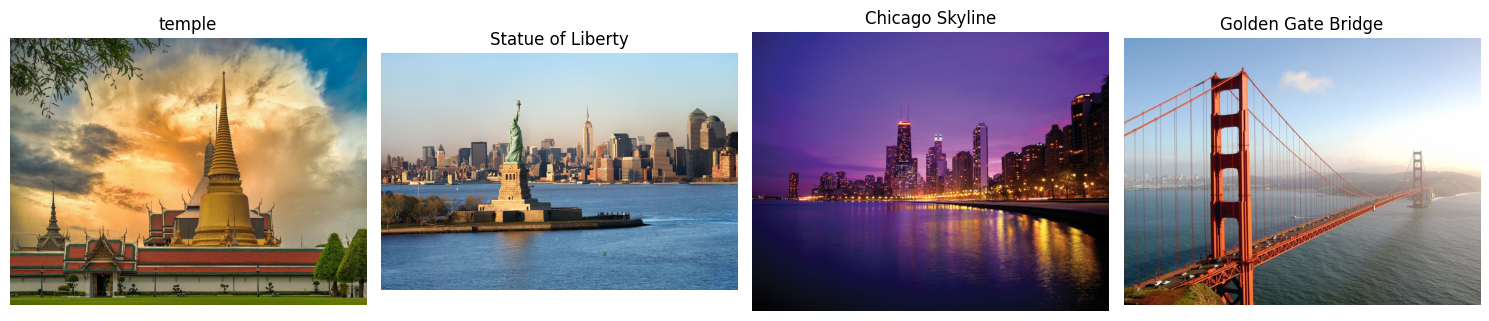

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor

# Function to load images from URLs (assuming load_image is part of your environment or defined elsewhere)
def load_image(url):
    from PIL import Image
    import requests
    from io import BytesIO
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# Load images from URLs

image0 = load_image("https://cdn.pixabay.com/photo/2023/05/16/09/15/bangkok-7997046_1280.jpg")
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
image2 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")
image3 = load_image("https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg")

# Display the images
images = [image0,image1, image2, image3]
titles = ["temple","Statue of Liberty", "Chicago Skyline", "Golden Gate Bridge"]

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for idx, (image, title) in enumerate(zip(images, titles)):
    axes[idx].imshow(image)
    axes[idx].set_title(title)
    axes[idx].axis("off")  # Turn off axes for better visualization

plt.tight_layout()
plt.show()

In [4]:
import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq



processor = AutoProcessor.from_pretrained("HuggingFaceM4/Idefics3-8B-Llama3")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceM4/Idefics3-8B-Llama3",
                                               torch_dtype=torch.bfloat16,
                                               device_map="auto")
                                        
                                


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty."},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "And how about this image?"},
        ]
    },       
]


prompt = processor.apply_chat_template(messages, add_generation_prompt=True)


In [6]:
%%time

inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt").to("cuda")


# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts)


["User:<image>What do we see in this image?\nAssistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty.\nUser:<image>And how about this image?\nAssistant: The image depicts a picturesque nighttime cityscape of New York City, showcasing the iconic skyline and the Statue of Liberty. The sky is painted in a gradient of purples and blues, suggesting either a sunset or sunrise, with the colors transitioning from deep blue at the top to a lighter shade near the horizon. The lighting of the city's buildings and lights reflects off the calm waters of the Hudson River, creating a mirrored effect that enhances the beauty of the scene.\n\nIn the foreground, the Statue of Liberty stands prominently on Liberty Island, her torch held high, symbolizing freedom and democracy. The statue is illuminated, casting a golden glow that contrasts with the cooler tones of the sky. The statue's pedestal and base are visible, and the surrounding area appears to be a p

In [7]:
from IPython.display import display, Markdown
Markdown(generated_texts[0])

User:<image>What do we see in this image?
Assistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty.
User:<image>And how about this image?
Assistant: The image depicts a picturesque nighttime cityscape of New York City, showcasing the iconic skyline and the Statue of Liberty. The sky is painted in a gradient of purples and blues, suggesting either a sunset or sunrise, with the colors transitioning from deep blue at the top to a lighter shade near the horizon. The lighting of the city's buildings and lights reflects off the calm waters of the Hudson River, creating a mirrored effect that enhances the beauty of the scene.

In the foreground, the Statue of Liberty stands prominently on Liberty Island, her torch held high, symbolizing freedom and democracy. The statue is illuminated, casting a golden glow that contrasts with the cooler tones of the sky. The statue's pedestal and base are visible, and the surrounding area appears to be a park or a green space, possibly Battery Park, which is a common viewpoint for this iconic landmark.

The city skyline is filled with a variety of buildings, ranging from modern skyscrapers to older structures. The Empire State Building, identifiable by its distinctive Art Deco spire, stands out prominently in the center of the skyline. Other notable buildings include the One World Trade Center, recognizable by its modern design and height, and the Chrysler Building, known for its distinctive art deco spire. The lights of the buildings are reflected in the water, adding to the overall vibrancy of the scene.

The water of the Hudson River is calm, with gentle ripples visible, reflecting the lights and colors of the city. The shoreline is lined with trees and possibly some greenery, adding a touch of nature to the urban landscape. The lighting along the shoreline is soft and ambient, contributing to the serene atmosphere of the image.

In summary, the image captures a serene and majestic view of New York City at dusk or dawn, with the Statue of Liberty as the focal point, surrounded by a skyline of iconic buildings and a calm, reflective river. The lighting and colors create a harmonious blend of natural and urban beauty.

In [8]:
import re


# Regular expression to extract User and Assistant lines
pattern = r"(User:.*?)(?=\nAssistant:|$)|(?<=\n)(Assistant:.*?)(?=\nUser:|$)"

# Find all matches
matches = re.findall(pattern, generated_texts[0] , re.DOTALL)

# Print the extracted lines
for user_line, assistant_line in matches:
    if user_line.strip():
        print(user_line.strip())
        print("\n")
    if assistant_line.strip():
        print(assistant_line.strip())
        print("\n")


User:<image>What do we see in this image?


Assistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty.


User:<image>And how about this image?


Assistant: The image depicts a picturesque nighttime cityscape of New York City, showcasing the iconic skyline and the Statue of Liberty. The sky is painted in a gradient of purples and blues, suggesting either a sunset or sunrise, with the colors transitioning from deep blue at the top to a lighter shade near the horizon. The lighting of the city's buildings and lights reflects off the calm waters of the Hudson River, creating a mirrored effect that enhances the beauty of the scene.

In the foreground, the Statue of Liberty stands prominently on Liberty Island, her torch held high, symbolizing freedom and democracy. The statue is illuminated, casting a golden glow that contrasts with the cooler tones of the sky. The statue's pedestal and base are visible, and the surrounding area appears to be a pa

# Test Next picutre

In [9]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
]


prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

In [10]:
%%time

inputs = processor(text=prompt, images=[image0], return_tensors="pt").to("cuda")

# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts)

['User:<image>What do we see in this image?\nAssistant: The image depicts a grand and ornate temple complex, likely of Thai architecture, set against a backdrop of a dramatic sky. The temple is characterized by its multi-tiered golden stupa, which is the central focus of the image. The stupa is adorned with intricate carvings and golden spires, reflecting the rich cultural heritage and religious significance of the structure. The stupa is surrounded by a series of smaller, equally ornate buildings, all of which share a similar architectural style, featuring red-tiled roofs and white walls.\n\nThe temple complex is set in a large, open courtyard, which is covered with lush green grass. The courtyard is bordered by neatly trimmed hedges and small trees, adding a touch of natural beauty to the scene. The sky above is a canvas of vibrant colors, transitioning from deep oranges and yellows at the horizon to a gradient of blues and purples towards the top, suggesting either a sunrise or suns

In [11]:
import re


# Regular expression to extract User and Assistant lines
pattern = r"(User:.*?)(?=\nAssistant:|$)|(?<=\n)(Assistant:.*?)(?=\nUser:|$)"

# Find all matches
matches = re.findall(pattern, generated_texts[0] , re.DOTALL)

# Print the extracted lines
for user_line, assistant_line in matches:
    if user_line.strip():
        print(user_line.strip())
        print("\n")
    if assistant_line.strip():
        print(assistant_line.strip())
        print("\n")

User:<image>What do we see in this image?


Assistant: The image depicts a grand and ornate temple complex, likely of Thai architecture, set against a backdrop of a dramatic sky. The temple is characterized by its multi-tiered golden stupa, which is the central focus of the image. The stupa is adorned with intricate carvings and golden spires, reflecting the rich cultural heritage and religious significance of the structure. The stupa is surrounded by a series of smaller, equally ornate buildings, all of which share a similar architectural style, featuring red-tiled roofs and white walls.

The temple complex is set in a large, open courtyard, which is covered with lush green grass. The courtyard is bordered by neatly trimmed hedges and small trees, adding a touch of natural beauty to the scene. The sky above is a canvas of vibrant colors, transitioning from deep oranges and yellows at the horizon to a gradient of blues and purples towards the top, suggesting either a sunrise or sunset.